# Import

In [33]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import supervision as sv
import torch
import cv2
import copy
import json

# CONF.

In [2]:
class cfg:
    car_part_path = "../models/checkpoints/yolov8x-car-part-detection-weight.pt"
    car_damage_path = "../models/checkpoints/yolov8l-car-damage-detection-weight.pt"
    deformation_path = "../models/checkpoints/resnet50_deformation_classification_acc=0.66.ckpt"
    image_size = 640
    conf_thres = 0.25
    iou_thres = 0.45

# Model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Classification

In [4]:
# IMPORT PYTORCH LIGHTNING LIBRARY APIs
import lightning.pytorch as pl
import torch
import torch.nn as nn
import timm


class cnnModel(pl.LightningModule):
    def __init__(
        self,
        model_name,
        num_classes
        ):
        super(cnnModel, self).__init__()
        self.save_hyperparameters() # tell the model to save the hyperparameters into the checkpoint file

        self.num_classes = num_classes

        self.model = timm.create_model(model_name, pretrained=True) # create model
        num_in_features = self.model.get_classifier().in_features # get number of penultimate layer's output

        ################# New Head ########################
        self.model.fc = nn.Sequential(
                    nn.Dropout(0.4),  # Move dropout before batch norm for potential regularization
                    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(in_features=512, out_features=self.num_classes, bias=False)
                    )# modify classify's head




    def forward(self, x):
        # batch -> ([list of images],[list of targets])
        # this forward method can be refer to model(x)
        # print("\nbatch \n", batch)

        logits = self.model(x)
        predictions = torch.nn.functional.softmax(logits, dim=1)  # Apply softmax
        predictions = predictions.argmax(dim=1)  # Get class indices
        # print(x)
        return predictions


/home/chogerlate/miniforge3/envs/dl-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
deformation_model = cnnModel.load_from_checkpoint(cfg.deformation_path)
deformation_model.to(device)

cnnModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momen

## YOLO

In [6]:
# Load model
car_part_model = YOLO(cfg.car_part_path).to(device)
car_damage_model = YOLO(cfg.car_damage_path).to(device)

# Inference

In [7]:
# Run inference
# input_path = "../data/car-with-damage/bl1.jpg"
input_path = [
   "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBMkhZLM7gSJMOU6Xpiqq7wXCvj0p3e565CfrgrV0hfw&s",
 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSpCUcRGPHxXjluLhwRaB7kj9ISdyOT88PvosmZQsVyj6Y8fSG7BVi40pkjYk902Wg21kw&usqp=CAU"
  ]
cp_result = car_part_model(input_path, imgsz=cfg.image_size, conf=cfg.conf_thres, iou=cfg.iou_thres)
cd_result = car_damage_model(input_path, imgsz=cfg.image_size, conf=cfg.conf_thres, iou=cfg.iou_thres)


0: 640x640 1 Front-bumper, 1 Grille, 1 Headlight, 1 Hood, 2 Mirrors, 1 Windshield, 1: 640x640 1 Back-door, 1 Back-wheel, 1 Back-window, 1 Fender, 1 Front-bumper, 1 Front-door, 1 Front-wheel, 1 Front-window, 1 Headlight, 1 Hood, 2 Mirrors, 1 Quarter-panel, 1 Rocker-panel, 1 Roof, 1 Windshield, 351.4ms
Speed: 4.8ms preprocess, 175.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 deformations, 1: 640x640 1 deformation, 213.1ms
Speed: 2.9ms preprocess, 106.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [73]:
car_damage_model.names

{0: 'car-part-crack',
 1: 'deformation',
 2: 'flat-tire',
 3: 'glass-crack',
 4: 'lamp-crack',
 5: 'scratch',
 6: 'side-mirror-crack'}

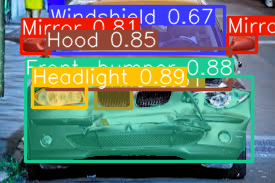

In [94]:
Image.fromarray(cp_result[0].plot())

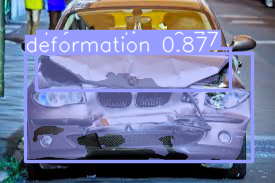

In [95]:
Image.fromarray(cd_result[0].plot())

In [10]:
cp_result[0].orig_img.shape

(183, 275, 3)

# Processing Results

In [12]:
def pre_processing_results(yolo_results):
    results = []
    id2class = yolo_results[0].names
    for result in yolo_results:
        result = result.cpu().numpy()
        data_dict = dict()
        data_dict['orig_img'] = result.orig_img
        data_dict['path'] = result.path
        data_dict["orig_shape"] = result.orig_shape
        data_dict["class_ids"] = result.boxes.cls
        data_dict['classes'] = [id2class[i] for i in result.boxes.cls] 
        data_dict["boxes"] = result.boxes.xyxyn
        data_dict["masks"] = result.masks.data 
        data_dict['conf'] = result.boxes.conf
        data_dict["instance_ids"] = [i for i in range(len(result.boxes.cls))]
        results.append(data_dict)
         
    return results    

cp = pre_processing_results(cp_result)
cd = pre_processing_results(cd_result)

In [13]:
mask = cp_result[0].cpu().numpy().masks.data
poly = sv.mask_to_polygons(mask[1])
len(mask),len(poly)

(7, 2)

In [14]:
def convert_masks_to_xyxy(masks):
    polygons = []
    for mask in masks:
        poly = sv.mask_to_polygons(mask)
        polygons.append(poly[0])
    return polygons

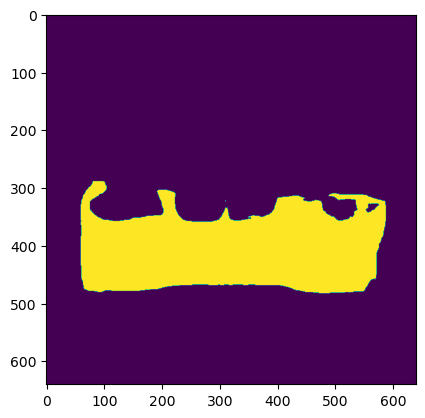

In [15]:
plt.imshow(mask[1])

In [16]:
result = [{'x': float(row[0]), 'y': float(row[1])} for row in poly[0]]
result

[{'x': 81.0, 'y': 289.0},
 {'x': 81.0, 'y': 290.0},
 {'x': 80.0, 'y': 291.0},
 {'x': 80.0, 'y': 293.0},
 {'x': 78.0, 'y': 295.0},
 {'x': 78.0, 'y': 296.0},
 {'x': 75.0, 'y': 299.0},
 {'x': 74.0, 'y': 299.0},
 {'x': 73.0, 'y': 300.0},
 {'x': 73.0, 'y': 301.0},
 {'x': 69.0, 'y': 305.0},
 {'x': 69.0, 'y': 306.0},
 {'x': 68.0, 'y': 307.0},
 {'x': 68.0, 'y': 308.0},
 {'x': 67.0, 'y': 309.0},
 {'x': 67.0, 'y': 310.0},
 {'x': 64.0, 'y': 313.0},
 {'x': 64.0, 'y': 316.0},
 {'x': 63.0, 'y': 317.0},
 {'x': 63.0, 'y': 319.0},
 {'x': 62.0, 'y': 320.0},
 {'x': 62.0, 'y': 321.0},
 {'x': 61.0, 'y': 322.0},
 {'x': 61.0, 'y': 328.0},
 {'x': 60.0, 'y': 329.0},
 {'x': 60.0, 'y': 356.0},
 {'x': 61.0, 'y': 357.0},
 {'x': 61.0, 'y': 358.0},
 {'x': 60.0, 'y': 359.0},
 {'x': 60.0, 'y': 364.0},
 {'x': 61.0, 'y': 365.0},
 {'x': 61.0, 'y': 383.0},
 {'x': 60.0, 'y': 384.0},
 {'x': 60.0, 'y': 434.0},
 {'x': 61.0, 'y': 435.0},
 {'x': 61.0, 'y': 456.0},
 {'x': 62.0, 'y': 457.0},
 {'x': 62.0, 'y': 459.0},
 {'x': 63.0,

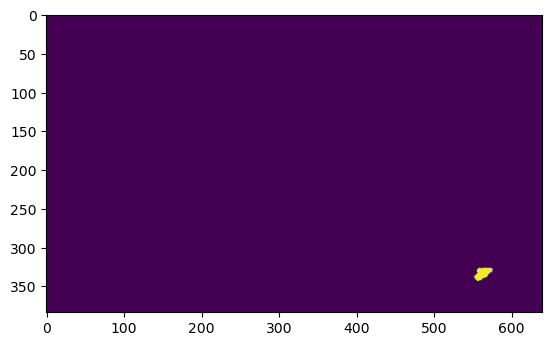

In [17]:
new_mask = [sv.polygon_to_mask(p, (640, 384)) for p in poly]
plt.imshow(new_mask[1])

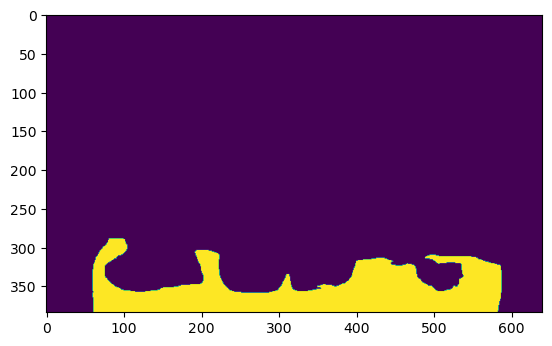

In [18]:
plt.imshow(new_mask[0])

In [19]:
def severity_determiner(model, car_damage_model_result):
    result = copy.deepcopy(car_damage_model_result)
    severity = []
    for id in  range(len(result['classes'])):
        cat = result['classes'][id]
        if cat == "deformation" :
            # load box that was in xyxyn format
            box = result['boxes'][id]
            # rescale transform them to xyxy format
            orig_shape = result['orig_shape']
            box[0],box[2] = box[0]*orig_shape[1], box[2]*orig_shape[1]
            box[1],box[3] = box[1]*orig_shape[0], box[3]*orig_shape[0]
            
            # load numpy image and crop image
            cropped_image = sv.crop_image(image=result['orig_img'], xyxy=box)
            # resize image to 224x224 before feeding into model
            resized_image = cv2.resize(cropped_image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            # convert image to tensor
            x = torch.from_numpy(resized_image)
            x = x.permute(2, 0, 1) # from NHWC to NCHW
            x = x.float() # convert to float
            x = x.unsqueeze(0) # add batch dimension
            x = x.to(device) # set device to cuda if available 
            with torch.no_grad():
                model.eval() # set model to evaluation mode
                model.to(device)
                pred = model(x).cpu().item() # result to cpu and get value instead of tensor
            severity.append(pred+1)
        else :
            severity.append(0)
        
    return severity

In [159]:
# next(deformation_model.parameters()) # returns a boolean
x = deformation_model.device
y = torch.tensor([1,2,3,]).to(x)
y

tensor([1, 2, 3], device='cuda:0')

In [103]:
damage_severity_id_to_class = {
            0: "None",
            1: "minor",
            2: "moderate",
            3: "severe"
            }
for i in range(len(cd)):
    severity = severity_determiner(deformation_model, cd[i])
    cd[i]['severity_id'] = severity
    cd[i]['severity'] = [damage_severity_id_to_class[i] for i in severity]

## Result convertion FN

In [51]:
#  {
#                 "x": 208.5,
#                 "y": 181,
#                 "width": 31,
#                 "height": 8,
#                 "confidence": 0.696,
#                 "class": "crack",
#                 "points": [
#                     {
#                     "x": 220.08,
#                     "y": 176.68
#                     },
#                     {
#                     "x": 220.08,
#                     "y": 176.68
#                     }
#                     ],
#                 "class_id": 0
#   }
 
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyArrayEncoder, self).default(obj)
    
def detection_result_to_json_format(result: dict):
    """convert pre processed prediction result to json format

    Args:
        result (dict): _description_
    """
    prediction_list = []
    for id in range(len(result['classes'])):
        result_dict = dict()
        # extract bounding box to xyxyn format
        box = result['boxes'][id]
        result_dict['x1'] = box[0]
        result_dict['y1'] = box[1]
        result_dict['x2'] = box[2]
        result_dict['y2'] = box[3]
        # confience score
        result_dict['confidence'] = result['conf'][id]
        # class
        result_dict['class'] = result['classes'][id]
        # coordinate points of polygons
        polygons = sv.mask_to_polygons(result['masks'][id])
        # get the first polygon
        points = [{'x': float(row[0]), 'y': float(row[1])} for row in polygons[0]]
        result_dict['points'] = points
        # get class ID
        result_dict['class_id'] = result['class_ids'][id] 
        # severity if any
        if 'severity_id' in result:
            result_dict['severity_id'] = result['severity_id'][id]
            result_dict['severity'] = result['severity'][id]
        # instance order
        result_dict['instance_id'] = result['instance_ids'][id]
        
        # add to list
        prediction_list.append(result_dict)
    return prediction_list
        
sample = detection_result_to_json_format(cp[0])
sample

[{'x1': 0.118136376,
  'y1': 0.4656488,
  'x2': 0.31583133,
  'y2': 0.58682543,
  'confidence': 0.8938982,
  'class': 'Headlight',
  'points': [{'x': 114.0, 'y': 308.0},
   {'x': 113.0, 'y': 309.0},
   {'x': 109.0, 'y': 309.0},
   {'x': 108.0, 'y': 310.0},
   {'x': 107.0, 'y': 310.0},
   {'x': 106.0, 'y': 311.0},
   {'x': 103.0, 'y': 311.0},
   {'x': 102.0, 'y': 312.0},
   {'x': 96.0, 'y': 312.0},
   {'x': 95.0, 'y': 313.0},
   {'x': 94.0, 'y': 313.0},
   {'x': 92.0, 'y': 315.0},
   {'x': 91.0, 'y': 315.0},
   {'x': 90.0, 'y': 316.0},
   {'x': 88.0, 'y': 316.0},
   {'x': 87.0, 'y': 317.0},
   {'x': 86.0, 'y': 317.0},
   {'x': 83.0, 'y': 320.0},
   {'x': 81.0, 'y': 320.0},
   {'x': 80.0, 'y': 321.0},
   {'x': 78.0, 'y': 321.0},
   {'x': 77.0, 'y': 322.0},
   {'x': 77.0, 'y': 323.0},
   {'x': 76.0, 'y': 324.0},
   {'x': 76.0, 'y': 338.0},
   {'x': 79.0, 'y': 341.0},
   {'x': 79.0, 'y': 342.0},
   {'x': 80.0, 'y': 343.0},
   {'x': 81.0, 'y': 343.0},
   {'x': 85.0, 'y': 347.0},
   {'x': 86

In [122]:
json.dumps(sample, cls =NumpyArrayEncoder)

'[{"x1": 0.11813637614250183, "y1": 0.4656488001346588, "x2": 0.31583133339881897, "y2": 0.586825430393219, "confidence": 0.8938981890678406, "class": "Headlight", "points": [{"x": 114.0, "y": 308.0}, {"x": 113.0, "y": 309.0}, {"x": 109.0, "y": 309.0}, {"x": 108.0, "y": 310.0}, {"x": 107.0, "y": 310.0}, {"x": 106.0, "y": 311.0}, {"x": 103.0, "y": 311.0}, {"x": 102.0, "y": 312.0}, {"x": 96.0, "y": 312.0}, {"x": 95.0, "y": 313.0}, {"x": 94.0, "y": 313.0}, {"x": 92.0, "y": 315.0}, {"x": 91.0, "y": 315.0}, {"x": 90.0, "y": 316.0}, {"x": 88.0, "y": 316.0}, {"x": 87.0, "y": 317.0}, {"x": 86.0, "y": 317.0}, {"x": 83.0, "y": 320.0}, {"x": 81.0, "y": 320.0}, {"x": 80.0, "y": 321.0}, {"x": 78.0, "y": 321.0}, {"x": 77.0, "y": 322.0}, {"x": 77.0, "y": 323.0}, {"x": 76.0, "y": 324.0}, {"x": 76.0, "y": 338.0}, {"x": 79.0, "y": 341.0}, {"x": 79.0, "y": 342.0}, {"x": 80.0, "y": 343.0}, {"x": 81.0, "y": 343.0}, {"x": 85.0, "y": 347.0}, {"x": 86.0, "y": 347.0}, {"x": 89.0, "y": 350.0}, {"x": 90.0, "y": 

In [53]:
cp[0]

{'orig_img': array([[[118, 145, 136],
         [ 54, 107,  94],
         [ 36,  98,  84],
         ...,
         [ 53,  49,  55],
         [ 45,  41,  47],
         [ 48,  44,  50]],
 
        [[109, 138, 129],
         [ 52, 102,  90],
         [ 37,  98,  84],
         ...,
         [ 47,  43,  49],
         [ 26,  22,  28],
         [ 35,  31,  37]],
 
        [[107, 141, 131],
         [ 56, 102,  90],
         [ 39,  93,  80],
         ...,
         [ 63,  59,  65],
         [ 22,  18,  24],
         [ 35,  31,  37]],
 
        ...,
 
        [[120, 149, 188],
         [117, 160, 187],
         [ 49, 115, 120],
         ...,
         [ 79,  93, 115],
         [ 79,  93, 115],
         [ 78,  92, 114]],
 
        [[ 48,  82, 112],
         [ 61, 111, 129],
         [  5,  78,  76],
         ...,
         [ 77,  91, 113],
         [ 77,  91, 113],
         [ 76,  90, 112]],
 
        [[ 29,  70,  93],
         [ 37,  92, 101],
         [ 16,  94,  83],
         ...,
         [ 77,  

## Interception

In [112]:
def find_intercept_report(car_damage_results, car_part_results):
    interception_instances = {
        "car_part": [],
        "damage": [], 
        # "damage id":[],
    }
    for part_id, part_mask in enumerate(car_part_results['masks']):
        
        interception_damages = []
        interception_ids = [] 
        for damage_id, damage_mask in enumerate(car_damage_results['masks']):
            if np.sum(damage_mask * part_mask) > 20:
                if car_damage_results['classes'][damage_id] == "deformation":
                    damage_name = car_damage_results["severity"][damage_id]+ " " + car_damage_results['classes'][damage_id]
                else :
                    damage_name = car_damage_results['classes'][damage_id]
                # interception_ids.append(damage_id)
                interception_damages.append(damage_name)
                
        # add row of interception
        # interception_instances['damage id'].append(interception_ids)
        interception_instances['car_part'].append(car_part_results['classes'][part_id])
        # convert list of damage to string
        interception_damages = ', '.join(interception_damages) if len(interception_damages) > 0 else ""
        interception_instances['damage'].append(interception_damages)
    report = pd.DataFrame(interception_instances)
    
    return report

sample_report = find_intercept_report(cd[0], cp[0])
sample_report                

,car_part,damage
0,Headlight,minor deformation
1,Front-bumper,minor deformation
2,Hood,"minor deformation, moderate deformation"
3,Mirror,
4,Mirror,
5,Windshield,moderate deformation
6,Grille,minor deformation


In [151]:
sample_report.to_dict(orient='series')

{'car_part': 0       Headlight
 1    Front-bumper
 2            Hood
 3          Mirror
 4          Mirror
 5      Windshield
 6          Grille
 Name: car_part, dtype: object,
 'damage': 0                          minor deformation
 1                          minor deformation
 2    minor deformation, moderate deformation
 3                                           
 4                                           
 5                       moderate deformation
 6                          minor deformation
 Name: damage, dtype: object}

## Create  JSON result

In [154]:

def export_result_to_json(  inputs, car_part_model_results, car_damage_model_results, car_part_model, car_damage_model):
    pipeline_result = dict()
    for image_id in range(len(inputs)):
        image_result = dict()
        # add image meta data 
        image_result["image_meta_data"] = { 
            "orig_shape": car_part_model_results[image_id]['orig_shape'],
            "n_car_parts": len(car_part_model_results[image_id]['classes']),
            "n_car_damages": len(car_damage_model_results[image_id]['classes']) 
        }
        image_result['car_part_results'] = detection_result_to_json_format(car_part_model_results[image_id])
        image_result['car_damage_results'] = detection_result_to_json_format(car_damage_model_results[image_id])
        image_result['report'] = find_intercept_report(car_damage_model_results[image_id],car_part_model_results[image_id]).to_dict(orient="list")
        
        # add to json result
        pipeline_result[inputs[image_id]] = image_result 

    
    # add meta data
    pipeline_result["meta_data"] = {
        "car_part_id_to_class":  car_part_model.names,
        "car_damage_id_to_class": car_damage_model.names,
        "damage_severity_id_to_class": {
            0: "None",
            1: "minor",
            2: "moderate",
            3: "severe"
            }
    }
    return pipeline_result

pipeline_result = export_result_to_json(input_path, cp, cd, car_part_model, car_damage_model)
pipeline_result

{'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBMkhZLM7gSJMOU6Xpiqq7wXCvj0p3e565CfrgrV0hfw&s': {'image_meta_data': {'orig_shape': (183,
    275),
   'n_car_parts': 7,
   'n_car_damages': 2},
  'car_part_results': [{'x1': 0.118136376,
    'y1': 0.4656488,
    'x2': 0.31583133,
    'y2': 0.58682543,
    'confidence': 0.8938982,
    'class': 'Headlight',
    'points': [{'x': 114.0, 'y': 308.0},
     {'x': 113.0, 'y': 309.0},
     {'x': 109.0, 'y': 309.0},
     {'x': 108.0, 'y': 310.0},
     {'x': 107.0, 'y': 310.0},
     {'x': 106.0, 'y': 311.0},
     {'x': 103.0, 'y': 311.0},
     {'x': 102.0, 'y': 312.0},
     {'x': 96.0, 'y': 312.0},
     {'x': 95.0, 'y': 313.0},
     {'x': 94.0, 'y': 313.0},
     {'x': 92.0, 'y': 315.0},
     {'x': 91.0, 'y': 315.0},
     {'x': 90.0, 'y': 316.0},
     {'x': 88.0, 'y': 316.0},
     {'x': 87.0, 'y': 317.0},
     {'x': 86.0, 'y': 317.0},
     {'x': 83.0, 'y': 320.0},
     {'x': 81.0, 'y': 320.0},
     {'x': 80.0, 'y': 321.0},
     {'x': 78.0, '

In [155]:
json_result = json.dumps(pipeline_result, cls =NumpyArrayEncoder)
json_result

'{"https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBMkhZLM7gSJMOU6Xpiqq7wXCvj0p3e565CfrgrV0hfw&s": {"image_meta_data": {"orig_shape": [183, 275], "n_car_parts": 7, "n_car_damages": 2}, "car_part_results": [{"x1": 0.11813637614250183, "y1": 0.4656488001346588, "x2": 0.31583133339881897, "y2": 0.586825430393219, "confidence": 0.8938981890678406, "class": "Headlight", "points": [{"x": 114.0, "y": 308.0}, {"x": 113.0, "y": 309.0}, {"x": 109.0, "y": 309.0}, {"x": 108.0, "y": 310.0}, {"x": 107.0, "y": 310.0}, {"x": 106.0, "y": 311.0}, {"x": 103.0, "y": 311.0}, {"x": 102.0, "y": 312.0}, {"x": 96.0, "y": 312.0}, {"x": 95.0, "y": 313.0}, {"x": 94.0, "y": 313.0}, {"x": 92.0, "y": 315.0}, {"x": 91.0, "y": 315.0}, {"x": 90.0, "y": 316.0}, {"x": 88.0, "y": 316.0}, {"x": 87.0, "y": 317.0}, {"x": 86.0, "y": 317.0}, {"x": 83.0, "y": 320.0}, {"x": 81.0, "y": 320.0}, {"x": 80.0, "y": 321.0}, {"x": 78.0, "y": 321.0}, {"x": 77.0, "y": 322.0}, {"x": 77.0, "y": 323.0}, {"x": 76.0, "y": 324.0}, {"x": 

In [160]:
type(json_result)

str

In [127]:
sample_report.to_json()

'{"car_part":{"0":"Headlight","1":"Front-bumper","2":"Hood","3":"Mirror","4":"Mirror","5":"Windshield","6":"Grille"},"damage":{"0":"minor deformation","1":"minor deformation","2":"minor deformation, moderate deformation","3":"","4":"","5":"moderate deformation","6":"minor deformation"}}'